# Form Recognition in Spark Ocr

End-to-end form recognition using VisualDocumentNerV2 and FormRelationExtractor.

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.11/"
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

import os
if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license

In [2]:
#%pip install ../../../python/dist/spark-ocr-3.11.0rc8+spark30.tar.gz

In [3]:
# install from PYPI using secret
#%pip install spark-ocr==$version+spark32 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [4]:
import pyspark
import sparkocr
import json
import os

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

from sparkocr.transformers import *
from sparkocr.utils import display_images
from sparkocr.enums import *

## Start spark session

In [5]:
from sparkocr import start
from pyspark import SparkConf

spark = start(secret, jar_path = spark_ocr_jar_path)
spark

Spark version: 3.2.1
Spark NLP version: 4.0.0
Spark NLP for Healthcare version: 4.0.0
Spark OCR version: 4.0.0



## Load image


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 150 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


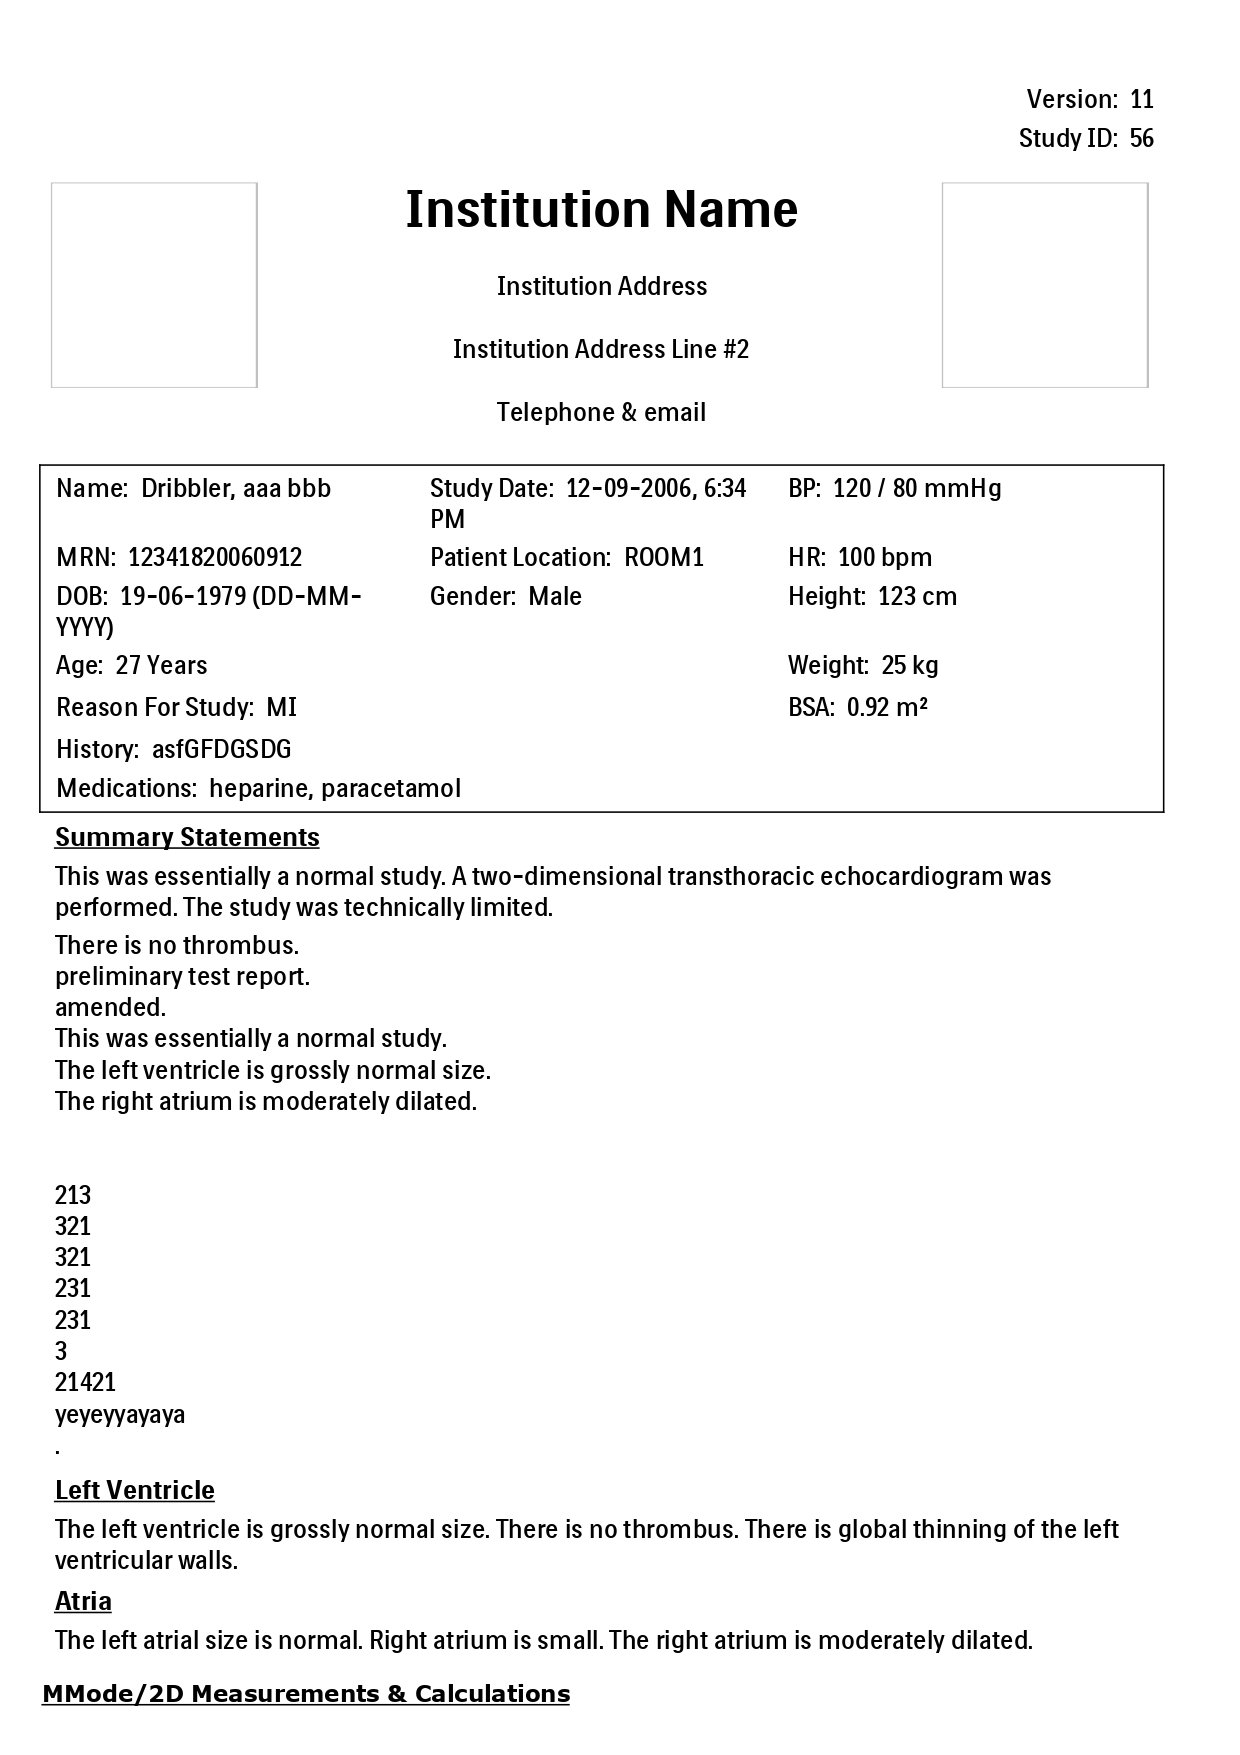

In [6]:
import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/forms/form1.jpg')
bin_df = spark.read.format("binaryFile").load(test_image_path)
display_images(BinaryToImage().transform(bin_df))

## Define pipeline

In [7]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

img_to_hocr = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = HocrTokenizer()\
    .setInputCol("hocr")\
    .setOutputCol("token")

doc_ner = VisualDocumentNerV2()\
    .pretrained("layoutlmv2_key_value_pairs", "en", "clinical/ocr")\
    .setInputCols(["token", "image"])\
    .setOutputCol("entities")

rel_extractor = FormRelationExtractor() \
    .setInputCol("entities") \
    .setOutputCol("relations")

draw_key_values = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("relations") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(Color.red)

draw_ner = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_ner") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(Color.red)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    doc_ner,
    rel_extractor,
    draw_key_values,
    draw_ner
])

## Call pipeline

In [8]:
results = pipeline.transform(bin_df).cache()

## Show resulst

In [9]:
results.select(f.explode("relations.result")).show(20, False)

+----------------------------------+
|col                               |
+----------------------------------+
|Name: Dribbler, bbb               |
|Study Date: 12-09-2006, 6:34      |
|BP: 120 80 mmHg                   |
|MRN: 12341820060912               |
|Patient Location: ROOM1           |
|HR: 100 bpm                       |
|DOB: 19-06-1979                   |
|Gender: Male                      |
|Height: 123 cm                    |
|Age: 27 Years                     |
|Weight: 25 kg                     |
|Reason For Study: MI              |
|BSA: 0.92 m2                      |
|History: asfGFDGSDG               |
|Medications: heparine, paracetamol|
+----------------------------------+



In [10]:
results.withColumn("metadata", f.explode("relations.metadata")) \
 .select(f.col("metadata.entity1").alias("key"), f.col("metadata.entity2").alias("value")).show(20, False)

+-----------------+---------------------+
|key              |value                |
+-----------------+---------------------+
|Name:            |Dribbler, bbb        |
|Study Date:      |12-09-2006, 6:34     |
|BP:              |120 80 mmHg          |
|MRN:             |12341820060912       |
|Patient Location:|ROOM1                |
|HR:              |100 bpm              |
|DOB:             |19-06-1979           |
|Gender:          |Male                 |
|Height:          |123 cm               |
|Age:             |27 Years             |
|Weight:          |25 kg                |
|Reason For Study:|MI                   |
|BSA:             |0.92 m2              |
|History:         |asfGFDGSDG           |
|Medications:     |heparine, paracetamol|
+-----------------+---------------------+



### Show NER results


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


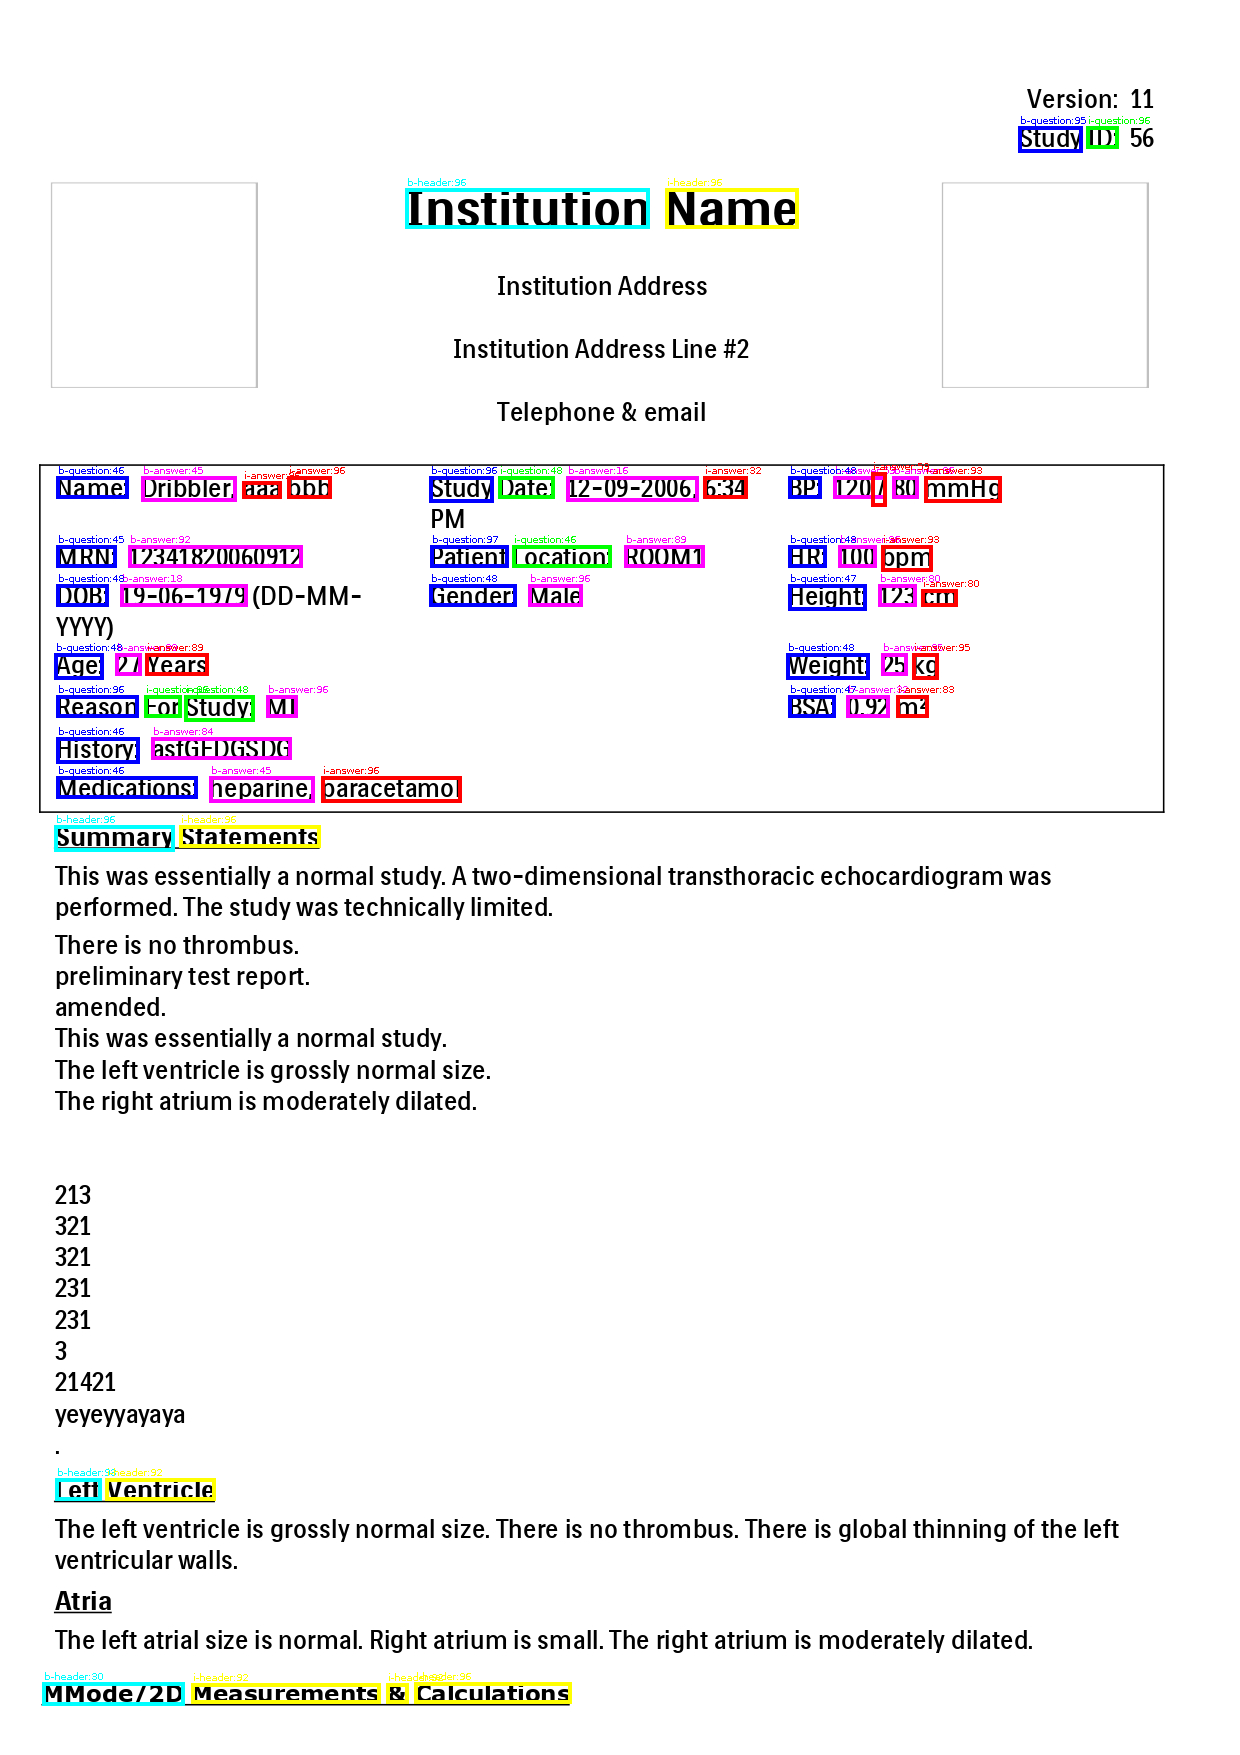

In [11]:
display_images(results, "image_with_ner")

### Show final annotations


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


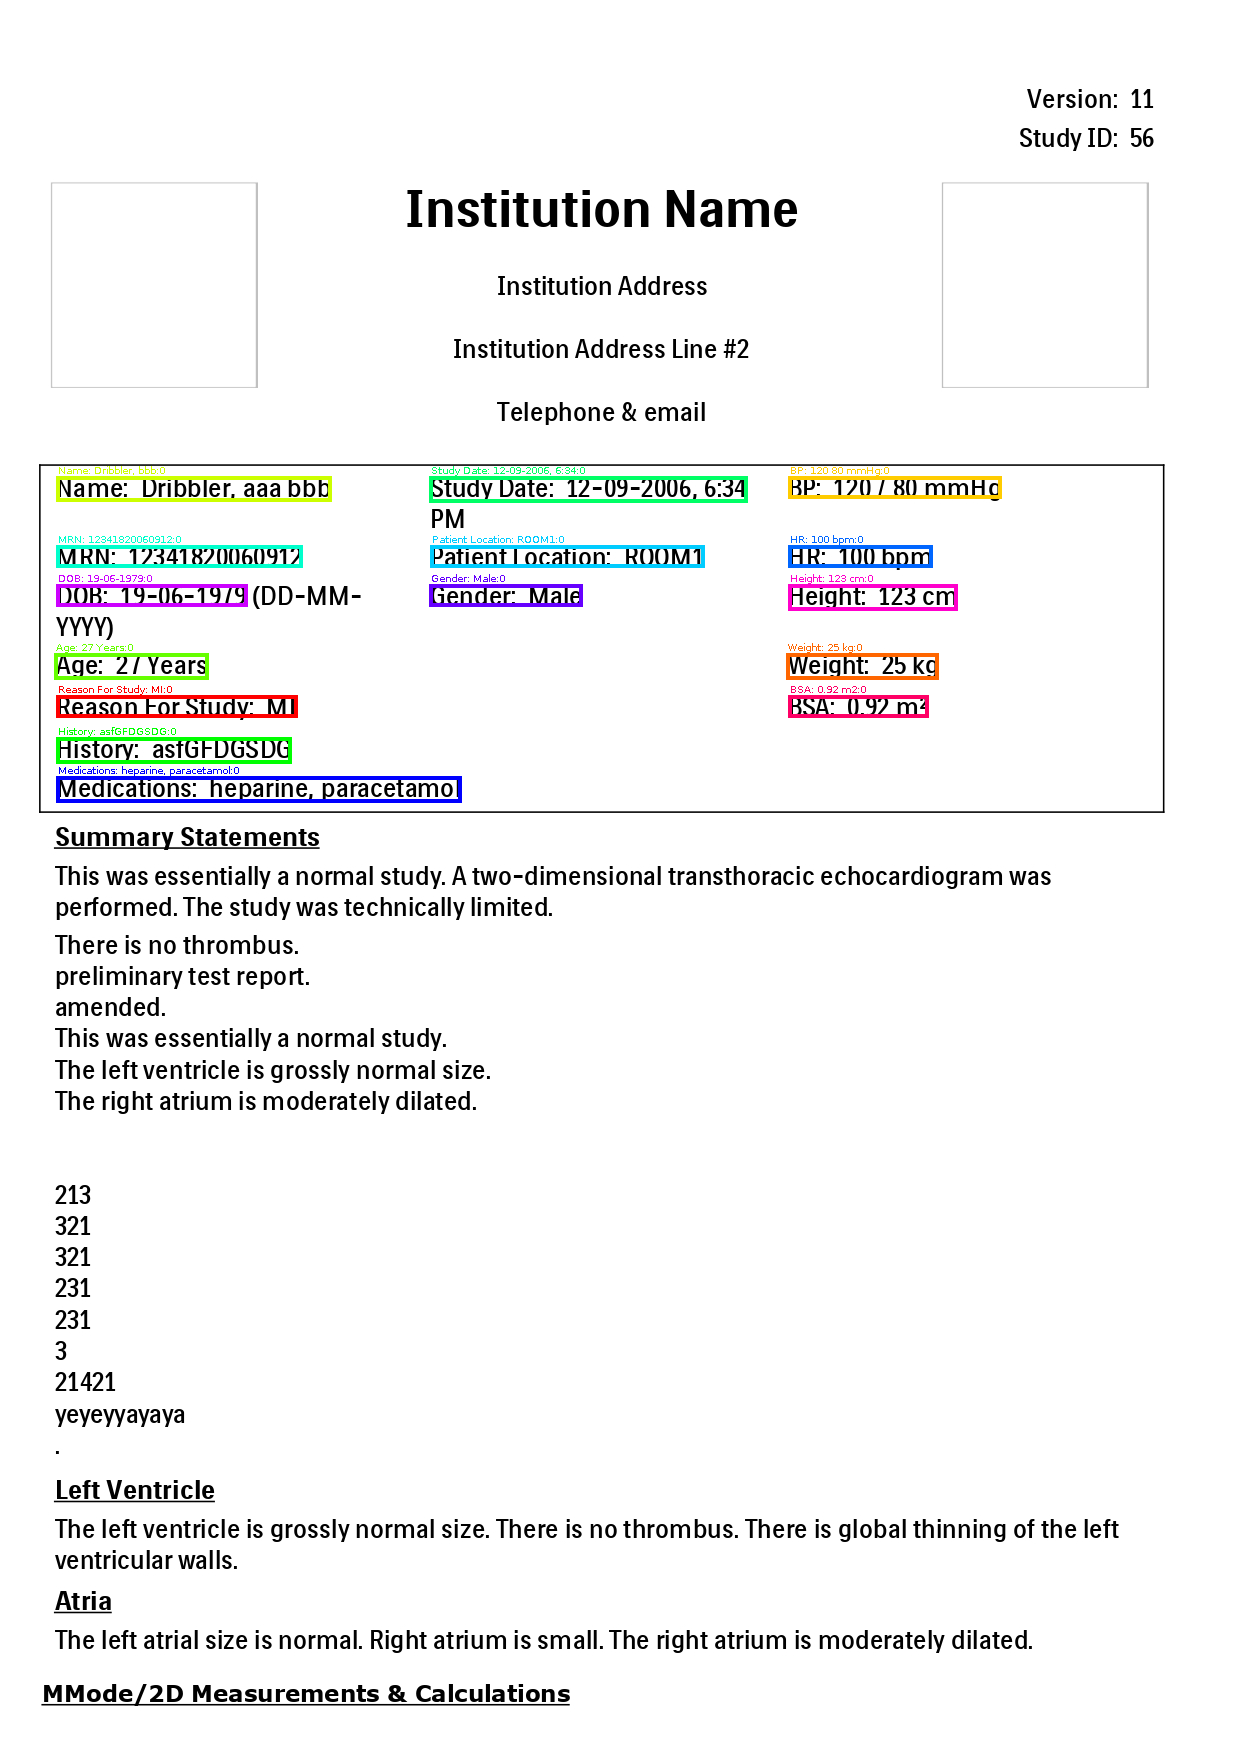

In [12]:
display_images(results, "image_with_annotations")